In [1]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Prepare for Dataset

In [2]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = open('./shakespeare.txt').read()
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 1115394
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [3]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [5]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 10       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        
        self.func1 = nn.RNNCell(self.input_size, self.hidden_size, nonlinearity='relu')
        self.func2 = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        hidden = self.func1(input, hidden)
        output = self.func2(hidden)

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return torch.zeros(1, self.hidden_size).to(device) 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (func1): RNNCell(100, 10, nonlinearity=relu)
  (func2): Linear(in_features=10, out_features=100, bias=True)
)

#### Training Step and Evaluation Step

In [6]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [7]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input[-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char)[0].to(device)

    return predicted_seq

#### Training Procedure

In [8]:
# Number of iterations.
iters       = 12300  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
#################change optimizer ###############################
opt       = torch.optim.Adadelta(net.parameters(), lr=0.005) 
#################change optimizer ###############################
loss_func = nn.CrossEntropyLoss()

count = 0
# Training procedure.
for i in range(iters):
    try:
        input, target = get_input_and_target()            # Fetch input and target.
    except: 
        count += 1
        print("Illegal characters:")
        print(count)
        continue
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/12300 loss:4.606856346130371
generated sequence: WMoc_W\2%(y_h<T1VGJ&A
6,WA"}srOj`Ud	u^]b|t}N$>y<M	"=O.6G~pB.TrJ$\

iter:199/12300 loss:4.600667953491211
U#3bIosRph5Oa?:QU%T}j9-"Y<'!sH>T~!Ch	$/
&)MWtG"Ft}~5muY=!o=h%N;W6I{osvsqb|N`

iter:299/12300 loss:4.59454870223999
generated sequence: W0i0d$K38it~wvuu{n5qAZ]y4K%A!%>Jl^>*>)Csd!7qELYM0`Aa|8zx`jmy7i(a/AZq2o8TH?(w:cxh^ah?3}q\yS3WNUd	}nA

iter:399/12300 loss:4.581577777862549
generated sequence: W1 EMoJ9=!$;.\]hX)DQv^d?t-=RS$$()wB3!wM-ckScS*m@?NwO0+C~a`_!{=jaFfnC+&Yp
;m4_b[pscwA#j6c,U8Au6Y0N

iter:499/12300 loss:4.575207233428955
XGCWt4ted sequence: WWnZw%Nt|7xO_%OqtY^P9[
JJ|Fg\Xo"kFfY!X.UY
Xc]K*L5
A~gv9"(wp)q~^Ja;s9^TB/uCV

iter:599/12300 loss:4.564220905303955
generated sequence: W(5~f<Y)j0MLlbg6[g(,^/|&i f9R	|ZI@or03%N]1$&}s0Pxy1Tz81RF&Pre:gx0N+I=~w&\yD;x
ppCTFUcC&)AJG#?N/]%

iter:699/12300 loss:4.551169395446777
y[LP0vfi_OK+V^^RPPrA1vl5%KiyOjPHQY&9L@wrn>'2PV2D'
o5BpCE5y|g5S%v.SgcZ7UMnk/^AFDtrnBrgDLf`Q

iter:799/1230

#### Training Loss Curve

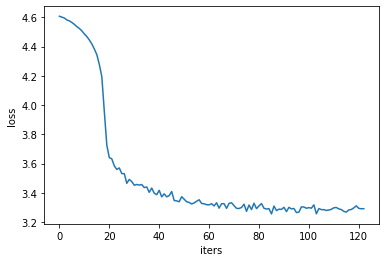

In [9]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

In [10]:
all_losses

[tensor(4.6069, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.6007, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.5945, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.5816, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.5752, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.5642, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.5512, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.5357, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.5232, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.5069, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.4857, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.4681, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.4445, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.4173, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.3831, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.3439, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.2772, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.1940

#### Evaluation: A Sample of Generated Sequence

In [11]:
print(eval_step(net, predicted_len=600))

WU*sfacn   ecNfodLerwtdrrew Pani n
arrdpte iaEwrgi eenego-aurh
o  ml widrn al!drf aoyIg,in

bisi f mcrslylli  
aeL ton 
tsy  h o
udan
efnctoce sthth Ae
ene:lton.nherewtedm it t noaTe
  A gwswtouo  ,lr yIo U
;heolt.abrwsda?aRsaea eIwhwn
et; o eutlefLds tiesnOv noo   eGaYleehueeirfIelharpot ptston dh  .IFa srCtsertaee ae uTllaTa othot hrirr
fhter,jueeh'eom,nodt eRa

 y
ldiniecdoOTdremhpr,hh,en;  fes R Rnoaodnh vkDoawvdetthomIknt ytdmeshseoeoaaTs
wnsaer;lrde Rb
siRnueai r,e re qit
neooI; ebmnor-:'tnwg kdaAeoao
tdnbIgtpTbr eltgdoOL thtTlOdc:
Tottss w
IIysatliZ ha
narW aftyy  Mtv
s;e ueerl e t roArR


In [12]:
import numpy as np
f = open("original_RNN_10.npy", "w")

In [13]:
a = [data.item() for data in all_losses]

In [14]:
a

[4.606856346130371,
 4.600667953491211,
 4.59454870223999,
 4.581577777862549,
 4.575207233428955,
 4.564220905303955,
 4.551169395446777,
 4.535660266876221,
 4.523187637329102,
 4.50694465637207,
 4.485726356506348,
 4.468074321746826,
 4.444479942321777,
 4.4173383712768555,
 4.383059501647949,
 4.34391975402832,
 4.277205467224121,
 4.194038391113281,
 3.9552371501922607,
 3.7262158393859863,
 3.6409029960632324,
 3.6325488090515137,
 3.584763765335083,
 3.5603556632995605,
 3.570575714111328,
 3.5321006774902344,
 3.531597852706909,
 3.465651273727417,
 3.4924001693725586,
 3.4774060249328613,
 3.4526655673980713,
 3.4575719833374023,
 3.453366279602051,
 3.457366943359375,
 3.43668794631958,
 3.4404091835021973,
 3.404142379760742,
 3.433331251144409,
 3.398423910140991,
 3.387909412384033,
 3.417478322982788,
 3.3733413219451904,
 3.393651247024536,
 3.3731939792633057,
 3.381791591644287,
 3.409379243850708,
 3.348297357559204,
 3.3457963466644287,
 3.3395473957061768,
 3.37407

In [15]:
np.save("original_RNN_10.npy", a)

In [16]:
np.load("original_RNN_10.npy")

array([4.60685635, 4.60066795, 4.5945487 , 4.58157778, 4.57520723,
       4.56422091, 4.5511694 , 4.53566027, 4.52318764, 4.50694466,
       4.48572636, 4.46807432, 4.44447994, 4.41733837, 4.3830595 ,
       4.34391975, 4.27720547, 4.19403839, 3.95523715, 3.72621584,
       3.640903  , 3.63254881, 3.58476377, 3.56035566, 3.57057571,
       3.53210068, 3.53159785, 3.46565127, 3.49240017, 3.47740602,
       3.45266557, 3.45757198, 3.45336628, 3.45736694, 3.43668795,
       3.44040918, 3.40414238, 3.43333125, 3.39842391, 3.38790941,
       3.41747832, 3.37334132, 3.39365125, 3.37319398, 3.38179159,
       3.40937924, 3.34829736, 3.34579635, 3.3395474 , 3.37407398,
       3.35697269, 3.3395679 , 3.33523679, 3.32479596, 3.33163023,
       3.34321094, 3.35330415, 3.32779503, 3.32580709, 3.31956816,
       3.31853604, 3.32601261, 3.31103325, 3.33278918, 3.29610014,
       3.32628894, 3.32632613, 3.29461765, 3.32863879, 3.33248997,
       3.31267047, 3.29466701, 3.29355907, 3.30071378, 3.32271

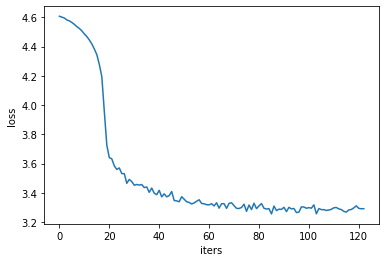

In [17]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(np.load("original_RNN_10.npy"))
plt.show()

In [18]:
## experiment different plotting

In [19]:
a = np.random.choice(100, 100)
b = np.random.choice(100, 100)
y = np.arange(100) #length of the loss

ValueError: Cannot load file containing pickled data when allow_pickle=False

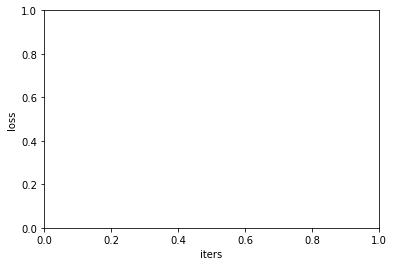

In [20]:
import numpy as np
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(np.load("original_RNN.npy"), label='RNN(Relu-100)')
plt.plot(np.load("original_RNN_tanh.npy"), label='RNN(tanh)')
plt.plot(np.load("original_RNN_10.npy"), label='RNN(Relu-10)')
plt.legend(loc='best')
plt.show()